<div style="text-align: center;">
    <h1><b>Practical Work 6 : Finite difference scheme for diffusion</b></h1>
</div>

*Authored in 2025 for educational purpose by S. Cardonna, Q. Richard, V. Lleras & P. Azerad. If you identify any issues or have suggestions for improvement, feel free to contact me.*  
  
**Introduction**  
This lab session focuses on solving the **heat/diffusion equation**  
$$
\partial_t u - \mu \partial_{xx} u = 0,
$$
using finite difference methods. The objective is to implement and analyze different numerical schemes, including:  
- **Explicit Forward Euler scheme**  
- **Implicit Backward Euler scheme**  
- **Crank-Nicolson scheme**  

The function `diffusion(mu, T, xmin, xmax, dx, dt, scheme)` computes the numerical solution $u(x,t)$ on a discretized domain, given an initial condition $u(x,0) = f(x)$. The solutions are evaluated based on their stability, accuracy, and computational efficiency.  

The study also explores the effect of varying the diffusion coefficient $\mu$, the time step $\Delta t$, and the spatial resolution $\Delta x$ on the behavior of each numerical scheme. Special attention is given to stability constraints, including the **CFL condition for diffusion** $r = \frac{\mu \Delta t}{\Delta x^2}$, and to how implicit methods allow for larger time steps compared to explicit schemes.


### Implementation of the three schemes ###

Running simulation for mu=0.5, dt=0.005...


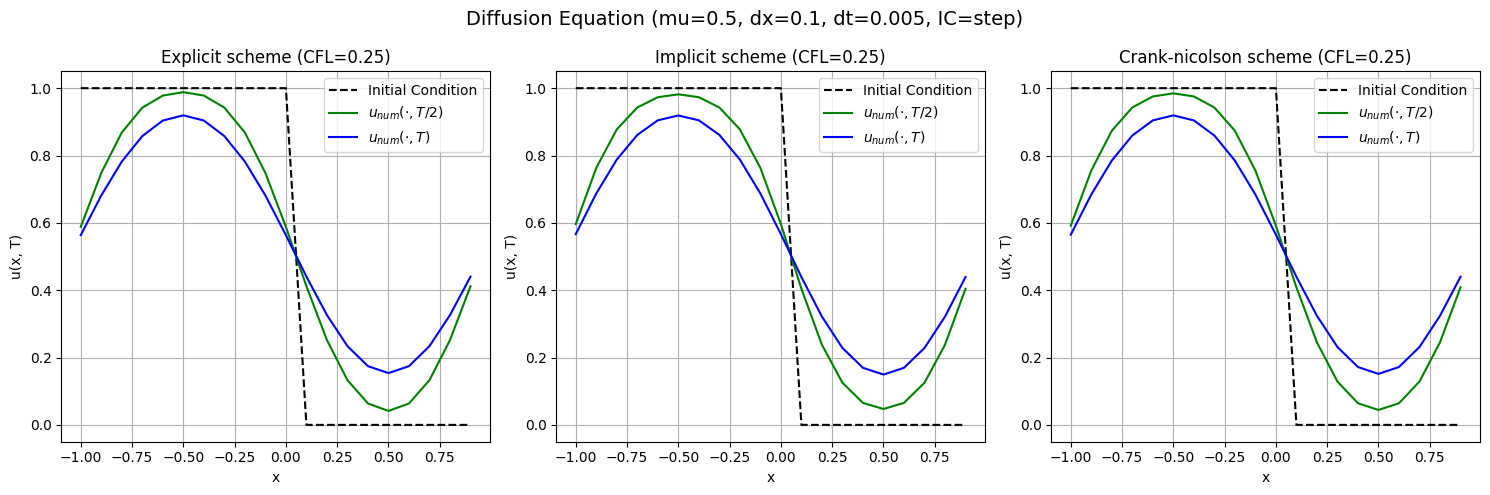

Running simulation for mu=0.5, dt=0.01...


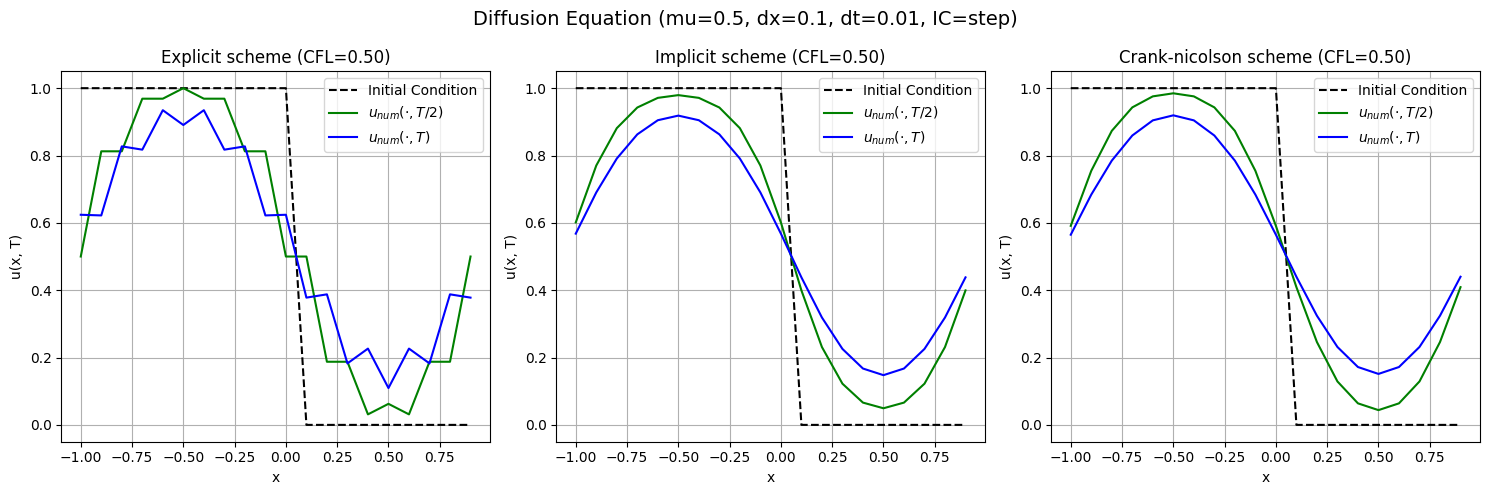

Running simulation for mu=0.5, dt=0.1...


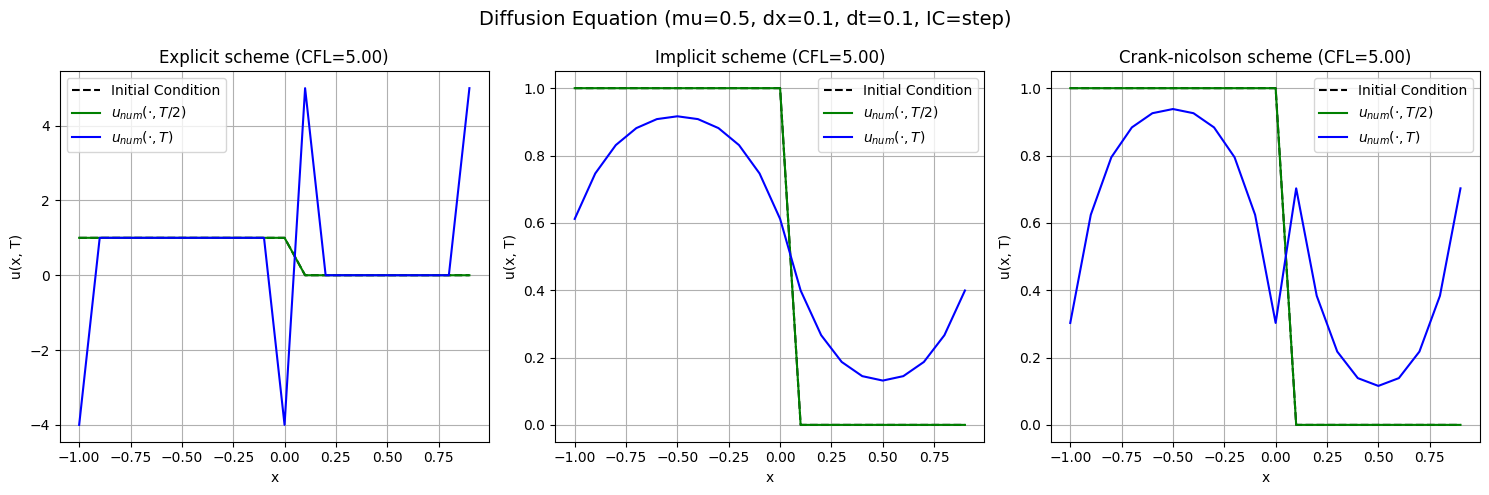

Running simulation for mu=-0.2, dt=0.005...


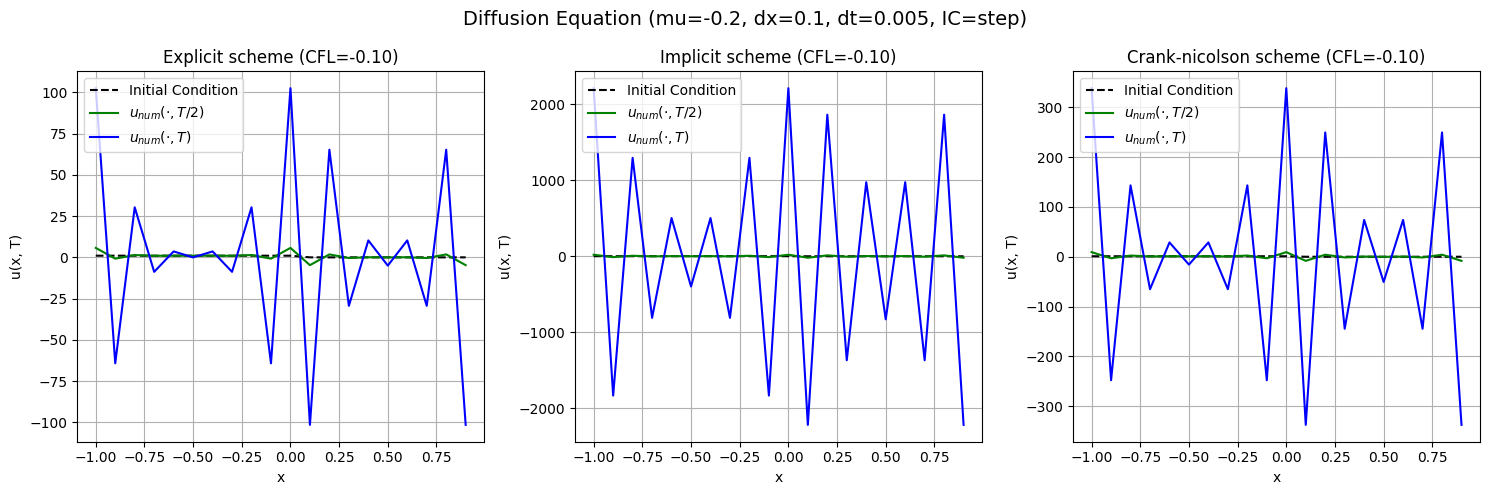

Running simulation for mu=-0.2, dt=0.01...


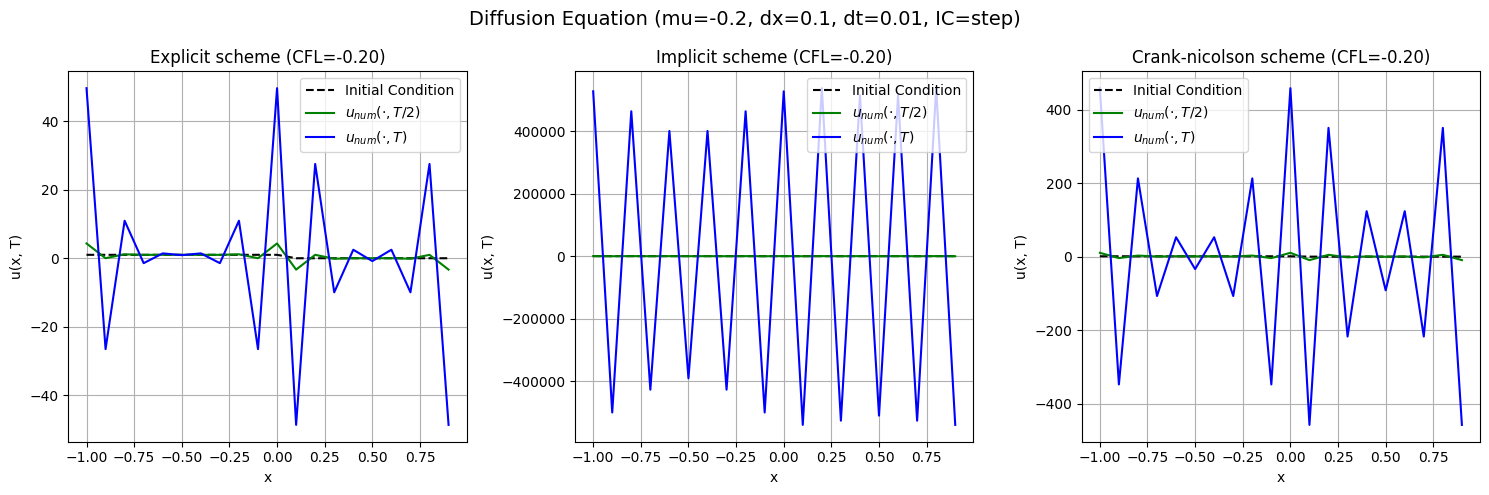

Running simulation for mu=-0.2, dt=0.1...


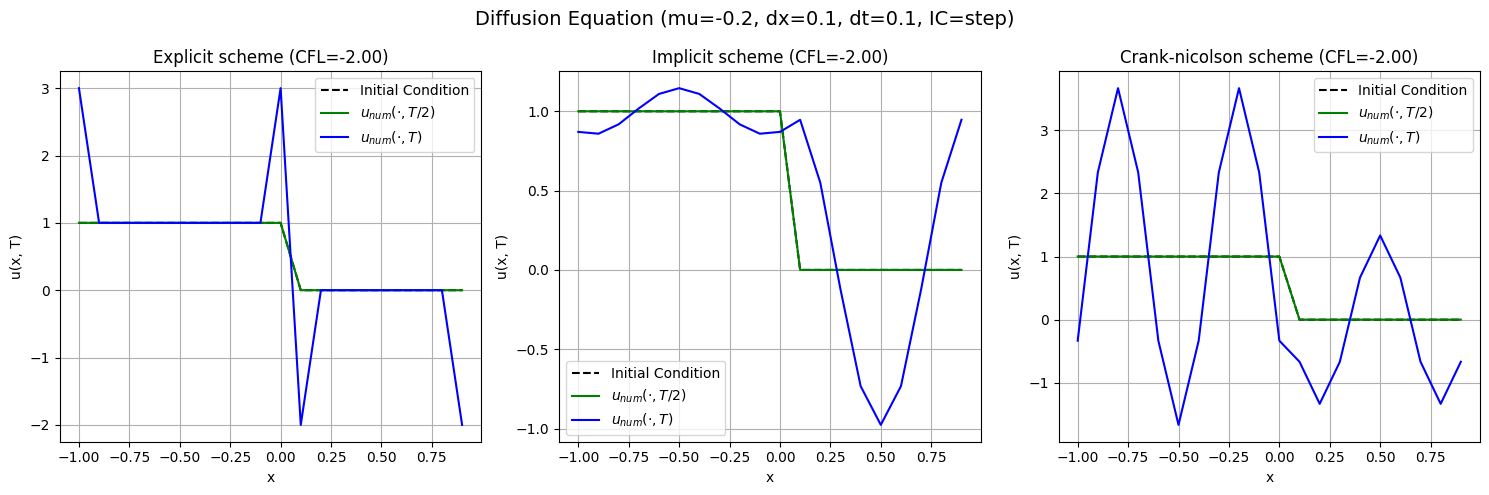

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def f(x, ic_type):
    """
    Defines the initial condition for the diffusion equation.
    
    Parameters:
    x (numpy array): Spatial grid.
    ic_type (str): Type of initial condition ('step', 'square', 'gaussian').
    
    Returns:
    numpy array: Initial condition values.
    """
    if ic_type == 'step':
        y = 1.0 * (x < 0)
    elif ic_type == 'square':
        y = 1.0 * ((-0.5 <= x) & (x < 0.5))
    elif ic_type == 'gaussian':
        y = np.exp(-25 * (x - (x.min() + x.max()) / 2) ** 2)
    else:
        raise ValueError("Unknown initial condition type. Choose from 'step', 'square', 'gaussian'.")
    
    return y

def diffusion(mu, T, xmin, xmax, dx, dt, scheme, ic_type):
    """
    Solves the diffusion equation u_t - mu u_xx = 0 using finite difference methods.
    
    Parameters:
    mu (float): Diffusion coefficient.
    T (float): Final time.
    xmin, xmax (float): Spatial domain limits.
    dx (float): Spatial step size.
    dt (float): Time step size.
    scheme (str): Scheme type ('explicit', 'implicit', 'crank-nicolson').
    ic_type (str): Initial condition type ('step', 'square', 'gaussian').
    
    Returns:
    x_vals, u_half, u_final (numpy arrays): Spatial grid, solution at T/2, and final solution.
    """
    x_vals = np.arange(xmin, xmax, dx)
    Nx = len(x_vals)
    Nt = int(T / dt)
    Nt_half = Nt // 2
    r = mu * dt / dx**2  # CFL number for diffusion
    
    # Initialize solution matrix
    u = np.zeros((Nx, Nt + 1))
    u[:, 0] = f(x_vals, ic_type)
    
    if scheme == 'explicit':
        # Explicit forward Euler scheme (conditionally stable, CFL < 0.5)
        for n in range(Nt):
            u_next = np.copy(u[:, n])
            u_next[1:-1] = r * u[:-2, n] + (1 - 2 * r) * u[1:-1, n] + r * u[2:, n]
            # Periodic boundary conditions
            u_next[0] = r * u[-1, n] + (1 - 2 * r) * u[0, n] + r * u[1, n]
            u_next[-1] = r * u[-2, n] + (1 - 2 * r) * u[-1, n] + r * u[0, n]
            u[:, n + 1] = u_next
    
    elif scheme == 'implicit':
        # Implicit backward Euler scheme (unconditionally stable, first-order accuracy in time)
        diagonals = [-r * np.ones(Nx-1), (1 + 2 * r) * np.ones(Nx), -r * np.ones(Nx-1)]
        A = diags(diagonals, [-1, 0, 1], format="csr").tolil()
        A[0, -1] = -r  # Periodic BC
        A[-1, 0] = -r  # Periodic BC
        A = A.tocsr()
        for n in range(Nt):
            u[:, n + 1] = spsolve(A, u[:, n])
    
    elif scheme == 'crank-nicolson':
        # Crank-Nicolson scheme (second-order accurate in time, unconditionally stable)
        diagonals_A = [-r/2 * np.ones(Nx-1), (1 + r) * np.ones(Nx), -r/2 * np.ones(Nx-1)]
        A = diags(diagonals_A, [-1, 0, 1], format="csr").tolil()
        A[0, -1] = -r/2  # Periodic BC
        A[-1, 0] = -r/2  # Periodic BC
        A = A.tocsr()
        
        diagonals_B = [r/2 * np.ones(Nx-1), (1 - r) * np.ones(Nx), r/2 * np.ones(Nx-1)]
        B = diags(diagonals_B, [-1, 0, 1], format="csr").tolil()
        B[0, -1] = r/2  # Periodic BC
        B[-1, 0] = r/2  # Periodic BC
        B = B.tocsr()
        
        for n in range(Nt):
            u[:, n + 1] = spsolve(A, B @ u[:, n])
    
    else:
        raise ValueError("Unknown scheme. Choose from 'explicit', 'implicit', 'crank-nicolson'.")
    
    return x_vals, u[:, Nt_half], u[:, -1]


def plot_schemes(mu, T, xmin, xmax, dx, dt, ic_type):
    """
    Runs all three schemes and plots them in a 1x3 subplot.
    """
    schemes = ["explicit", "implicit", "crank-nicolson"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Diffusion Equation (mu={mu}, dx={dx}, dt={dt}, IC={ic_type})", fontsize=14)
    
    for i, scheme in enumerate(schemes):
        x_vals, u_half, u_final = diffusion(mu, T, xmin, xmax, dx, dt, scheme, ic_type)
        ax = axes[i]
        ax.plot(x_vals, f(x_vals, ic_type), 'k--', label="Initial Condition")
        ax.plot(x_vals, u_half, 'g-', label=r"$u_{num}(\cdot, T/2)$")
        ax.plot(x_vals, u_final, 'b-', label=r"$u_{num}(\cdot, T)$")
        ax.set_title(f"{scheme.capitalize()} scheme (CFL={mu * dt / dx**2:.2f})")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x, T)")
        ax.legend()
        ax.grid()
    
    plt.tight_layout()
    plt.show()

# Parameters
mu_values = [0.5, -0.2]  # Test both positive and negative mu
dx = 0.1
dt_values = [0.005, 0.01, 0.1]  # Test different dt values
T = 0.1  # Final time
xmin, xmax = -1, 1  # Spatial domain

for mu in mu_values:
    for dt in dt_values:
        print(f"Running simulation for mu={mu}, dt={dt}...")
        plot_schemes(mu, T, xmin, xmax, dx, dt, ic_type='step')

### A brief remark about diffusion coefficient ###

When the diffusion coefficient $\mu$ is **negative**, all numerical schemes produce **unphysical and unstable solutions**. This occurs because the **mathematical problem itself is ill-posed** when $\mu < 0$. The diffusion equation is given by:
$$
\partial_t u - \mu \partial_{xx} u = 0.
$$
For a well-posed **parabolic** problem, the diffusion term $\mu \partial_{xx} u$ must act as a **smoothing operator**, spreading out information over time. This requires **$\mu > 0$**.

However, when $\mu < 0$, the equation transforms into:
$$
\partial_t u + |\mu| \partial_{xx} u = 0.
$$
This resembles a backward heat equation, which is a highly ill-posed problem. Instead of diffusing, the solution amplifies small perturbations exponentially, leading to unbounded growth and numerical instability. Thus, the instability observed in simulations is not due to the numerical method, but rather due to **the impossibility of solving a mathematically ill-posed problem**.